# **Ola Case Study - Ensemble Learning**
**Prathik Cherian**

Ola is a leading ride-sharing platform, aiming to provide reliable, affordable, and convenient urban transportation for everyone. The aim of this case study is to help Ola deal with its constant challenge : the churn rate of its drivers. Needless to say, it is crucial to ensure driver loyalty and reducing attrition.

Through this case study we will analyze driver data to reveal patterns in driver behavior, performance, and satisfaction. This would help in foreseeing potential churn, allowing proactive measures. 

By leveraging ensemble learning, we will try to predict driver churn, and thereby *driving* Ola's driver retention strategy.

---
## **Basic EDA and Data Wrangling**

We will begin with a basic exploratory data analysis of the data set.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

data = pd.read_csv('driver.csv')
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 5.1 MB


In [2]:
data.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [3]:
np.all(data.index == data['Unnamed: 0'])

np.True_

> Thus, we can drop the first column since it is exactly the same as the index of the dataframe.

In [ ]:
data = data.drop(columns=['Unnamed: 0'])
data.memory_usage(deep=True).sum()/1024**2  # in MBs

np.float64(4.952517509460449)

Let us standardize the column names.

In [ ]:
rename_dict = {
    'Dateofjoining': 'Joining_Date',
    'LastWorkingDate': 'Last_Working_Date',
    'MMM-YY': 'Reporting_Date',
    'Joining Designation': 'Joining_Designation',
    'Last Designation': 'Last_Designation',
    'Total Business Value': 'Total_Business_Value',
    'Quarterly Rating': 'Quarterly_Rating'
}
data = data.rename(columns=rename_dict)

In [6]:
data.sample(3, random_state=42)

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Joining_Date,Last_Working_Date,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating
18299,07/01/19,2674,29.0,1.0,C11,1,64610,03/12/17,07/09/19,1,2,0,1
9376,11/01/19,1386,27.0,1.0,C26,2,25458,25/06/19,NaN,1,1,202640,1
4518,10/01/20,672,30.0,0.0,C18,2,77011,29/08/20,NaN,2,2,0,1


In [7]:
data.shape

(19104, 13)

In [8]:
data.duplicated().sum()

np.int64(0)

In [9]:
data.isna().sum()/len(data)*100

Reporting_Date           0.000000
Driver_ID                0.000000
Age                      0.319305
Gender                   0.272194
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Joining_Date             0.000000
Last_Working_Date       91.541039
Joining_Designation      0.000000
Grade                    0.000000
Total_Business_Value     0.000000
Quarterly_Rating         0.000000
dtype: float64

In [10]:
data.Driver_ID.nunique()

2381

> In the given dataset, we have a total of 19104 records with 13 features corresponding to a total of 2381 unique drivers. We will need to aggregate the data (on `Driver_ID`) to have a single record for each driver.

> There are no duplicate records in the data set.

> But we do have missing values to deal with in `Age`, `Gender` and `Last_Working_Date` columns. So we will need to see how they can be imputed - using SimpleImputer, or KNNImputer etc.


Lets convert the date-related features to pandas `datetime` dtype.

In [ ]:
# inspecting the date columns
data['Reporting_Date'].unique()[:10], data['Last_Working_Date'].unique()[
    :10], data['Joining_Date'].unique()[:10]

(array(['01/01/19', '02/01/19', '03/01/19', '11/01/20', '12/01/20',
        '12/01/19', '01/01/20', '02/01/20', '03/01/20', '04/01/20'],
       dtype=object),
 array([nan, '03/11/19', '27/04/20', '03/07/19', '15/11/20', '21/12/19',
        '25/11/20', '22/02/19', '20/07/19', '30/04/19'], dtype=object),
 array(['24/12/18', '11/06/20', '12/07/19', '01/09/19', '31/07/20',
        '19/09/20', '12/07/20', '29/06/19', '28/05/15', '16/10/20'],
       dtype=object))

In [12]:
date_format = '%d/%m/%y'
date_cols = ['Reporting_Date', 'Last_Working_Date', 'Joining_Date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col], format=date_format, errors='coerce')

Let us inspect the drivers with missing `Age` values.

In [ ]:
# array of Driver_IDs with null Age
drivers_with_null_age = data[data.Age.isnull()]['Driver_ID'].unique()
# all records of drivers with null Age
data[data.Driver_ID.isin(drivers_with_null_age)]

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Joining_Date,Last_Working_Date,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating
68,2019-01-10,20,26.0,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
69,2019-01-11,20,26.0,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
70,2019-01-12,20,26.0,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
71,2020-01-01,20,26.0,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
72,2020-01-02,20,NaN,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19025,2019-01-03,2774,40.0,0.0,C15,1,42313,2018-07-21,NaT,1,1,2335840,4
19026,2019-01-04,2774,40.0,0.0,C15,1,42313,2018-07-21,NaT,1,1,106880,2
19027,2019-01-05,2774,40.0,0.0,C15,1,42313,2018-07-21,NaT,1,1,250000,2
19028,2019-01-06,2774,40.0,NaN,C15,1,42313,2018-07-21,NaT,1,1,0,2


In [ ]:
x = data[data.Driver_ID.isin(drivers_with_null_age)].groupby(
    'Driver_ID')['Age'].nunique()
np.any(x == 0), np.all(x >= 1)

(np.False_, np.True_)

> We know that `nunique()` does not count null values. Thus, from the above code output, we are able to confirm that there are no drivers with missing ages. There exists atleast one record for each driver with non-null age value and we can use that to impute the missing value.

> So this is some sort of data entry error rather than value actually missing.

We now conduct a similar analysis for `Gender` column and its null values.

In [ ]:
# array of Driver_IDs with null Gender
drivers_with_null_gender = data[data.Gender.isnull()]['Driver_ID'].unique()
# all records of drivers with null Gender
data[data.Driver_ID.isin(drivers_with_null_gender)]

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Joining_Date,Last_Working_Date,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating
239,2019-01-01,43,27.0,1.0,C15,0,12906,2018-07-13,NaT,1,1,359890,1
240,2019-01-02,43,27.0,NaN,C15,0,12906,2018-07-13,2019-02-20,1,1,0,1
257,2019-01-01,49,21.0,0.0,C20,0,53039,2018-05-25,NaT,1,2,171760,1
258,2019-01-02,49,21.0,NaN,C20,0,53039,2018-05-25,NaT,1,2,0,1
259,2019-01-03,49,21.0,0.0,C20,0,53039,2018-05-25,NaT,1,2,392890,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19025,2019-01-03,2774,40.0,0.0,C15,1,42313,2018-07-21,NaT,1,1,2335840,4
19026,2019-01-04,2774,40.0,0.0,C15,1,42313,2018-07-21,NaT,1,1,106880,2
19027,2019-01-05,2774,40.0,0.0,C15,1,42313,2018-07-21,NaT,1,1,250000,2
19028,2019-01-06,2774,40.0,NaN,C15,1,42313,2018-07-21,NaT,1,1,0,2


In [16]:
x = data[data.Driver_ID.isin(drivers_with_null_gender)]
y = x.groupby('Driver_ID')['Gender'].nunique()
np.all(y == 1)

np.True_

> Thus, we see that even in the cases where some drivers have records with missing gender, that is present in other records for the same driver. 

> We have also cross-checked that all drivers have only a single gender on file. Therefore, there is no need for any dramatic intervention.

Similary, we check non-unique values for other columns.

In [37]:
cols = ['City', 'Education_Level', 'Income', 'Joining_Date',
        'Joining_Designation', 'Grade', 'Total_Business_Value', 'Quarterly_Rating']
uniq_cols = []
non_uniq_cols = []
for _, col in enumerate(cols):
    x = data.groupby('Driver_ID')[col].nunique()
    if np.all(x.astype('int8') == 1):
        # print(f"{_+1}: {col} has only 1 unique value per driver")
        uniq_cols.append(col)
    else:
        # print(f"{_+1}: {col} has more than 1 non-unique values at least for some drivers")
        non_uniq_cols.append(col)

print("Columns with only 1 unique value per driver:")
print(uniq_cols)

print("Columns with more than 1 non-unique value per driver:")
print(non_uniq_cols)

Columns with only 1 unique value per driver:
['City', 'Education_Level', 'Joining_Date', 'Joining_Designation']
Columns with more than 1 non-unique value per driver:
['Income', 'Grade', 'Total_Business_Value', 'Quarterly_Rating']


> We see that the value of `City`, `Education_Level` is also not changing and remains the same for each driver ie drivers are not changing cities or their education level while at Ola. 

> But we see that there are multiple values that exist for `Income`, `Grade`, `Total_Business_Value`, `Quarterly_Rating` etc. This is not surprising but should be further investigated to gain specific insights.

We will look at the change in quarterly rating (from first to last):

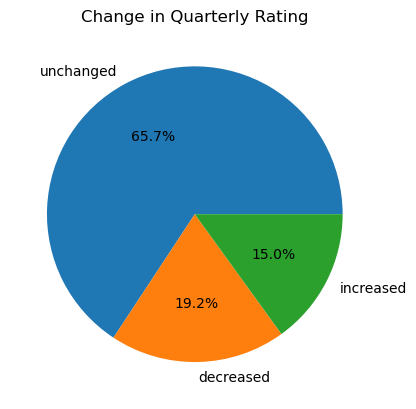

In [ ]:
rating_change = data.sort_values(['Driver_ID', 'Reporting_Date']).groupby(
    'Driver_ID')['Quarterly_Rating'].agg(['first', 'last'])
conditions = [rating_change['last'] > rating_change['first'], rating_change['last']
              < rating_change['first'], rating_change['last'] == rating_change['first']]
values = ['increased', 'decreased', 'unchanged']
rating_change['Rating_Status'] = np.select(
    conditions, values, default='unknown')
(rating_change['Rating_Status'].value_counts(normalize=True) *
 100).plot(kind='pie', autopct='%1.1f%%', title='Change in Quarterly Rating')
plt.ylabel('')
plt.show()

> We see that only a very small minority of drivers see positive increase in quarterly ratings (15%). The rest 85% see no improvement or worse, have decreasing ratings!

Similarly, we inspect change in income:

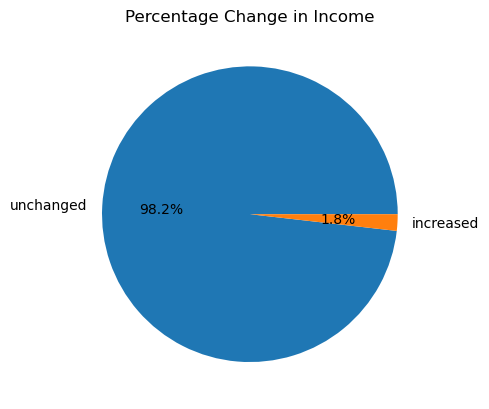

In [ ]:
income_change = data.sort_values(['Driver_ID', 'Reporting_Date']).groupby(
    'Driver_ID')['Income'].agg(['first', 'last'])
conditions = [income_change['last'] > income_change['first'], income_change['last']
              < income_change['first'], income_change['last'] == income_change['first']]
values = ['increased', 'decreased', 'unchanged']
income_change['Income_Status'] = np.select(
    conditions, values, default='unknown')

(income_change['Income_Status'].value_counts(normalize=True) *
 100).plot(kind='pie', autopct='%1.1f%%', title='Percentage Change in Income')
plt.ylabel('')
plt.show()

> We see that almost all of the drivers see no increase in their income from Ola (98.2%). This can be a significant factor in driver dissatisfaction and therefore lead to churn.

Change in grade:

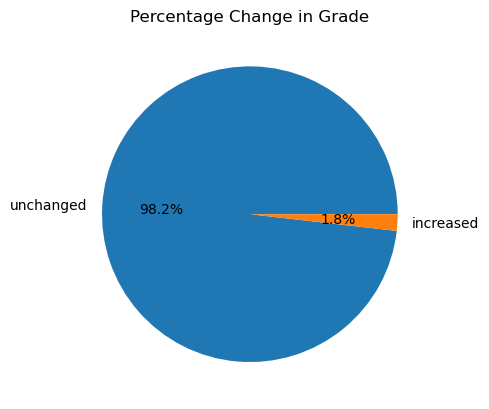

In [ ]:
grade_change = data.sort_values(['Driver_ID', 'Reporting_Date']).groupby(
    'Driver_ID')['Grade'].agg(['first', 'last'])
conditions = [grade_change['last'] > grade_change['first'], grade_change['last']
              < grade_change['first'], grade_change['last'] == grade_change['first']]
values = ['increased', 'decreased', 'unchanged']
grade_change['Grade_Status'] = np.select(conditions, values, default='unknown')

(grade_change['Grade_Status'].value_counts(normalize=True) *
 100).plot(kind='pie', autopct='%1.1f%%', title='Percentage Change in Grade')
plt.ylabel('')
plt.show()

> We see that almost all of the drivers see no change in their grade (98.2%). This can be also be factor in leading to churn.

Change in business value:

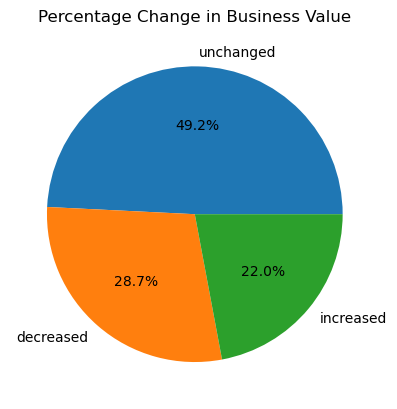

In [ ]:
bus_val_change = data.sort_values(['Driver_ID', 'Reporting_Date']).groupby(
    'Driver_ID')['Total_Business_Value'].agg(['first', 'last'])
conditions = [bus_val_change['last'] > bus_val_change['first'], bus_val_change['last']
              < bus_val_change['first'], bus_val_change['last'] == bus_val_change['first']]
values = ['increased', 'decreased', 'unchanged']
bus_val_change['Business_Value_Status'] = np.select(
    conditions, values, default='unknown')

(bus_val_change['Business_Value_Status'].value_counts(normalize=True)*100).plot(
    kind='pie', autopct='%1.1f%%', title='Percentage Change in Business Value')
plt.ylabel('')
plt.show()

> Interestingly, we see that only 28.7% of drivers have decreasing business value for ola. 22% show an increase and almost half atleast do maintain their business value to the company.

### Data Aggregation

Now we will proceed to create an aggregated dataframe containing the data for each driver.

In [ ]:
agg_dict = {
    'Age': 'max',  # some drivers have aged up during the period of data collection, so we choose the maximum age
    'Gender': 'last',  # gender is not changing, so we can take the last non-null value
    'City': 'last',  # city is not changing, so we can take the last non-null value
    # education level is not changing, so we can take the last non-null value
    'Education_Level': 'last',
    'Income': 'last',  # income is not changing, so we can take the last non-null value
    'Joining_Date': 'min',  # we take the minimum date of joining
    # designation is not changing, so we can take the first non-null value
    'Joining_Designation': 'first',
    'Grade': 'last',  # grade is not changing, so we can take the last non-null value
    'Total_Business_Value': 'sum',  # we take the sum of the business values
    'Quarterly_Rating': 'mean',  # we take the mean of the quarterly ratings
    # we take the last working date to see if the driver is still active or not
    'Last_Working_Date': 'max',
}

df = data.groupby('Driver_ID').agg(agg_dict).reset_index()
df

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining_Date,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating,Last_Working_Date
0,1,28.0,0.0,C23,2,57387,2018-12-24,1,1,1715580,2.000000,2019-11-03
1,2,31.0,0.0,C7,2,67016,2020-06-11,2,2,0,1.000000,NaT
2,4,43.0,0.0,C13,2,65603,2019-07-12,2,2,350000,1.000000,2020-04-27
3,5,29.0,0.0,C9,0,46368,2019-09-01,1,1,120360,1.000000,2019-07-03
4,6,31.0,1.0,C11,1,78728,2020-07-31,3,3,1265000,1.600000,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,34.0,0.0,C24,0,82815,2015-10-15,2,3,21748820,2.625000,NaT
2377,2785,34.0,1.0,C9,0,12105,2020-08-28,1,1,0,1.000000,2020-10-28
2378,2786,45.0,0.0,C19,0,35370,2018-07-31,2,2,2815090,1.666667,2019-09-22
2379,2787,28.0,1.0,C20,2,69498,2018-07-21,1,1,977830,1.500000,2019-06-20


In [139]:
# percentage of missing values in each column
df.isna().sum()/len(df)*100

Driver_ID                0.000000
Age                      0.000000
Gender                   0.000000
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Joining_Date             0.000000
Joining_Designation      0.000000
Grade                    0.000000
Total_Business_Value     0.000000
Quarterly_Rating         0.000000
Last_Working_Date       32.129357
dtype: float64

> We see that almost a third of the drivers have missing values for the `LastWorkingDate` column. These can be considered as the drivers still with the company. And therefore, `LastWorkingDate` can provide us our target feature.

In [ ]:
mask = df['Last_Working_Date'].isna()
df['Churn'] = np.where(mask, 'no', 'yes')
df = df.drop(columns=['Last_Working_Date'])
df.Churn.value_counts()

Churn
yes    1616
no      765
Name: count, dtype: int64

We will include the status of grade, income, rating etc into our dataframe as follows:

In [ ]:
df = pd.merge(df, grade_change.iloc[:, -1], on='Driver_ID', how='left')
df = pd.merge(df, income_change.iloc[:, -1], on='Driver_ID', how='left')
df = pd.merge(df, bus_val_change.iloc[:, -1], on='Driver_ID', how='left')
df = pd.merge(df, rating_change.iloc[:, -1], on='Driver_ID', how='left')

We will further create features such as joining month, joining year, etc as follows:

In [ ]:
df['Joining_Day'] = df['Joining_Date'].dt.day
df['Joining_Month'] = df['Joining_Date'].dt.month
df['Joining_Year'] = df['Joining_Date'].dt.year
df = df.drop(columns=['Joining_Date'])

We convert categorical features into category dtype to save memory:

In [ ]:
df['Gender'] = df['Gender'].map({0.0: 'Male', 1.0: 'Female'})
cat_cols = ['Gender', 'City', 'Education_Level', 'Joining_Designation',
            'Grade', 'Churn', 'Grade_Status', 'Rating_Status', 'Income_Status',
            'Business_Value_Status', 'Joining_Day', 'Joining_Month', 'Joining_Year']
for col in cat_cols:
    df[col] = df[col].astype('category')

We can also drop `Driver_ID` from our dataset as it has no bearing on churn.

In [ ]:
df = df.drop(columns=['Driver_ID'])
df = df[['Age', 'Gender', 'City', 'Education_Level', 'Income', 'Joining_Day',
         'Joining_Month', 'Joining_Year', 'Joining_Designation', 'Grade', 'Total_Business_Value',
         'Quarterly_Rating',  'Grade_Status', 'Income_Status', 'Business_Value_Status', 'Rating_Status', 'Churn']]
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Age                    2381 non-null   float64 
 1   Gender                 2381 non-null   category
 2   City                   2381 non-null   category
 3   Education_Level        2381 non-null   category
 4   Income                 2381 non-null   int64   
 5   Joining_Day            2381 non-null   category
 6   Joining_Month          2381 non-null   category
 7   Joining_Year           2381 non-null   category
 8   Joining_Designation    2381 non-null   category
 9   Grade                  2381 non-null   category
 10  Total_Business_Value   2381 non-null   int64   
 11  Quarterly_Rating       2381 non-null   float64 
 12  Grade_Status           2381 non-null   category
 13  Income_Status          2381 non-null   category
 14  Business_Value_Status  2381 non-null   c

> Thus, we now have created an aggregated dataframe (`df`) from our original dataset that consolidates the data about each of the 2381 drivers. 

> There are 17 features in total : 13 categorical and the rest 4 numerical. 


We look at the statistical summaries :

In [ ]:
df[['Age', 'Income', 'Total_Business_Value', 'Quarterly_Rating']].describe()[
    1:]  # for numerical columns

,Age,Income,Total_Business_Value,Quarterly_Rating
mean,33.663167,59334.157077,4.586742e+06,1.566304
std,5.983375,28383.666384,9.127115e+06,0.719652
min,21.000000,10747.000000,-1.385530e+06,1.000000
25%,29.000000,39104.000000,0.000000e+00,1.000000
50%,33.000000,55315.000000,8.176800e+05,1.000000
75%,37.000000,75986.000000,4.173650e+06,2.000000
max,58.000000,188418.000000,9.533106e+07,4.000000


> The average age of our driver is 33.66 having a mean income of 59334.16 and mean quarterly rating of 1.56 and mean total business value of 45.8 lakhs.

> Range of age is from 21 to 58 years with a median value of 33.

> Range of income is from 10747 to 188418 with a median value of 55315. 

> The total business value generated ranges from -13.8 lakhs to 953 lakhs with a median value of only 8 lakhs. 

> The bottom 25% of drivers produce no business value or incur outright losses (negative value).

In [ ]:
df.describe(include='category')[1:]  # for categorical columns

,Gender,City,Education_Level,Joining_Designation,Grade,Grade_Status,Income_Status,Business_Value_Status,Rating_Status,Churn
unique,2,29,3,5,5,2,2,3,3,2
top,Male,C20,2,1,2,unchanged,unchanged,unchanged,unchanged,yes
freq,1404,152,802,1026,855,2338,2338,1172,1565,1616


> We see that the dataset is imbalanced with over 67% drivers churning and the rest staying.

> There are driver data from 29 cities with C20 being the city with most drivers.

> The status columns (`*_status` : Grade, Income, Business_value and Rating) all have 'unchanged' as the most frequent value meaning most drivers do not see any increase in any of these variables (Grade, Income, Business_Value and Rating) and are instead having stagnant/lesser values.

> Most drivers have education level 2 and join the company at the designation 1. 

---
## **EDA - Univariate and Bivariate Analysis**

We now conduct univariate and bivariate analyses before we build ML models to predict churn.

In [ ]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'orange',
          'purple', 'pink', 'brown', 'gray', 'olive', 'cyan']
rng = np.random.default_rng(69)

### **Univariate Analysis**

#### Numerical Columns


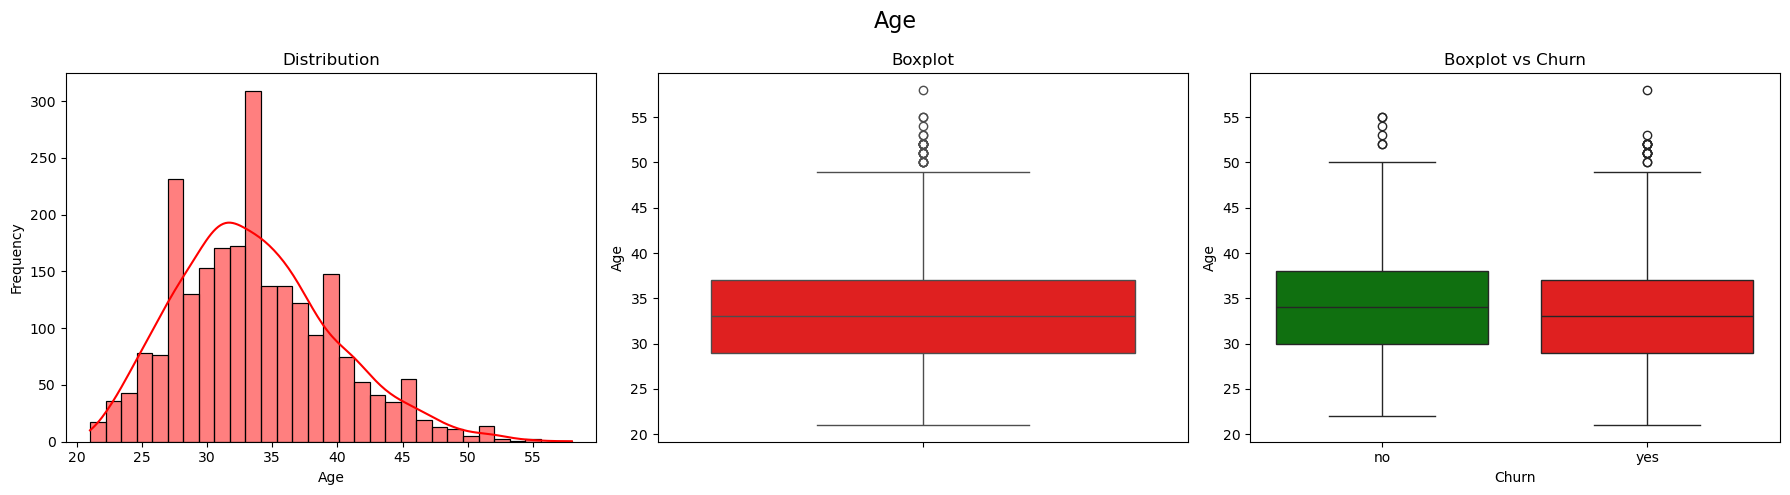

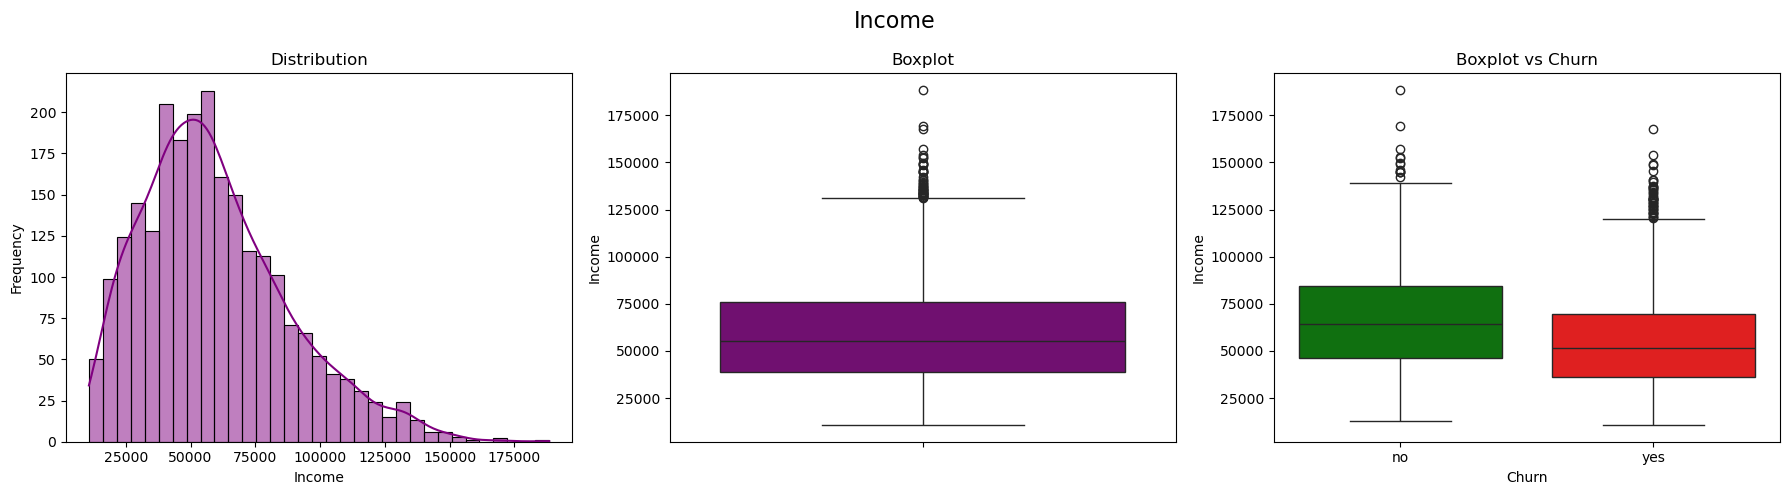

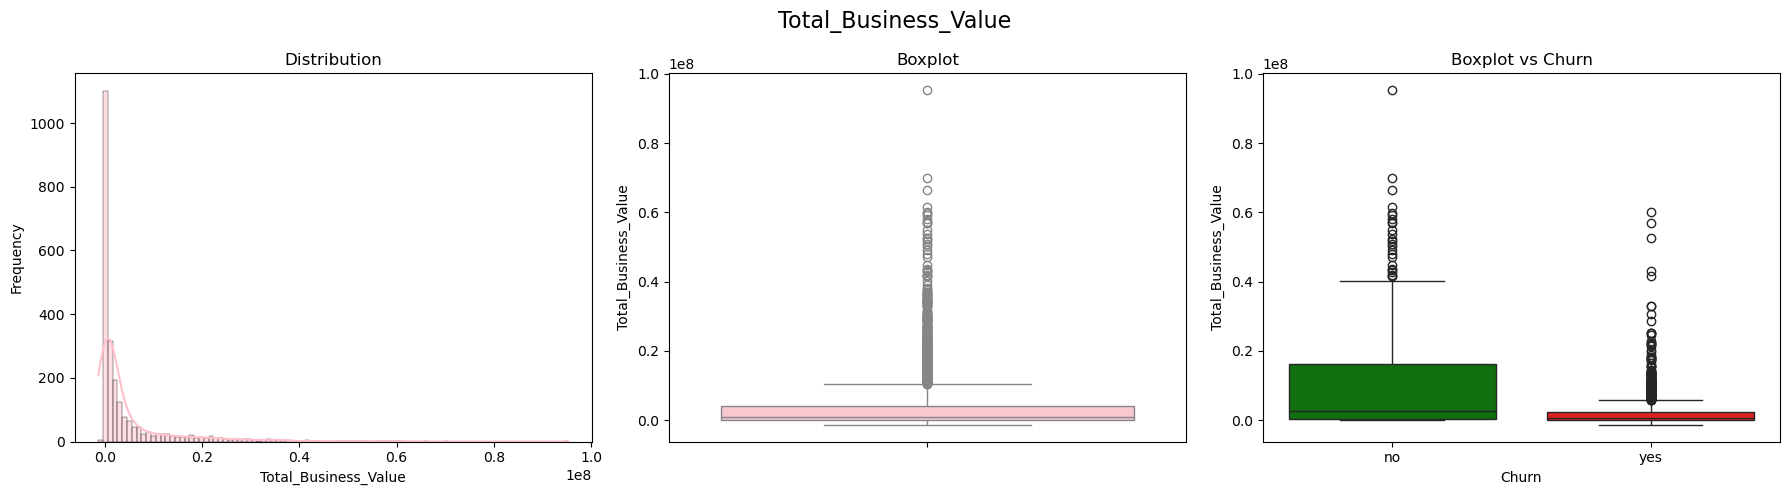

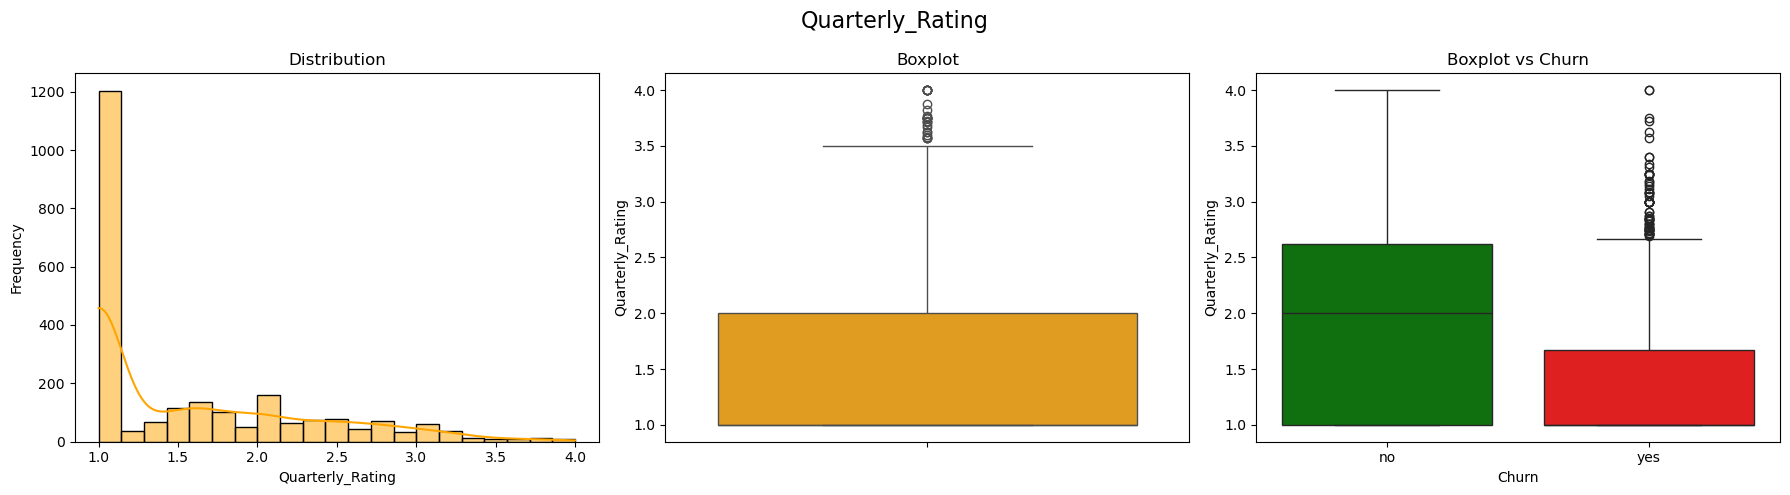

In [ ]:
# plotting histograms and boxplots for numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in num_cols:
    plt.figure(figsize=(18, 5))
    clr = rng.choice(colors, 1)[0]
    plt.suptitle(f'{col}', fontsize=16)
    plt.subplot(1, 3, 1)
    # plt.figure(figsize=(6,4))
    sns.histplot(df, x=col, kde=True, color=clr)
    plt.title(f'Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.subplot(1, 3, 2)
    sns.boxplot(data=df, y=col, color=clr)
    plt.title(f'Boxplot')
    plt.ylabel(col)
    plt.xlabel('')
    plt.subplot(1, 3, 3)
    sns.boxplot(data=df, y=col, x='Churn', hue='Churn', palette=['g', 'r'])
    plt.title(f'Boxplot vs Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [40]:
df.skew(numeric_only=True)

Age                     0.539098
Income                  0.779471
Total_Business_Value    3.361335
Quarterly_Rating        1.095329
dtype: float64

> All the distributions have positive skews meaning they are right skewed (ie longer right tails). Age and Income variables are relatively symmetric with low positive values of skews. Total business value is extremely right skewed meaning that the vast majority of drivers produce low business value. Quarterly ratings are also similar with a moderately high right skew - majority have low quarterly ratings.

> From the box plots it is clear that we do have outliers present in our data in each of the numerical columns - Age, Income, Total Business Value and Quarterly Rating. It is also observed that the outliers are all in the higher end and we do not have any outliers in the lower end.

> Should consider how to deal with the outliers - to keep, to clip, to scale (using `RobustScaler`) or to remove entirely. Intuitively, it does not make sense to remove outliers as these might hold valuable information about churn patterns. Moreover, given that we are using decision tree models to build our models, we do not need to remove/modify the outliers as tree models are generally robust to outliers. 

#### Categorical Columns

First we will look at `Churn` which is our target variable.

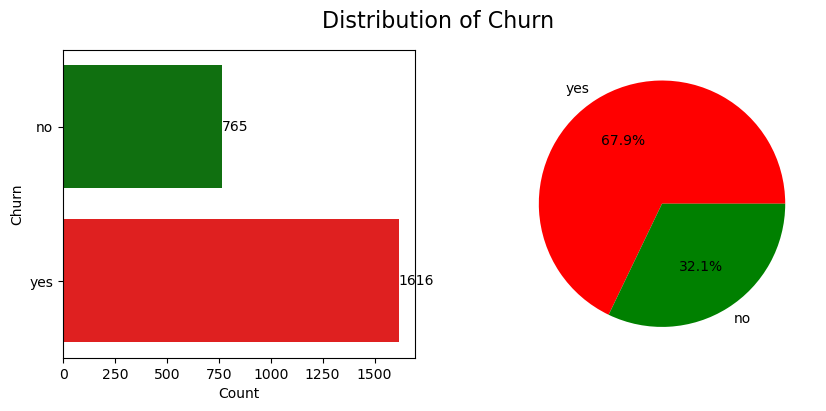

In [ ]:
plt.figure(figsize=(10, 4))
plt.suptitle('Distribution of Churn', fontsize=16)
plt.subplot(1, 2, 1)
bar = sns.countplot(data=df, y='Churn', hue='Churn', palette=['g', 'r'])
for value in bar.containers:
    bar.bar_label(value)
plt.ylabel('Churn')
plt.xlabel('Count')
plt.subplot(1, 2, 2)
(df.Churn.value_counts(normalize=True) *
 100).plot(kind='pie', autopct='%1.1f%%', colors=['r', 'g'])
plt.ylabel('')
plt.show()

> We see that only less than a third of Ola's drivers stay loyal and remain with the company. Almost 68% of the drivers are leaving the company.

In [ ]:
cat_cols = df.select_dtypes(include='category').columns.tolist()
cat_cols.remove('Churn')  # excluding target variable
cat_cols

['Gender',
 'City',
 'Education_Level',
 'Joining_Day',
 'Joining_Month',
 'Joining_Year',
 'Joining_Designation',
 'Grade',
 'Grade_Status',
 'Income_Status',
 'Business_Value_Status',
 'Rating_Status']

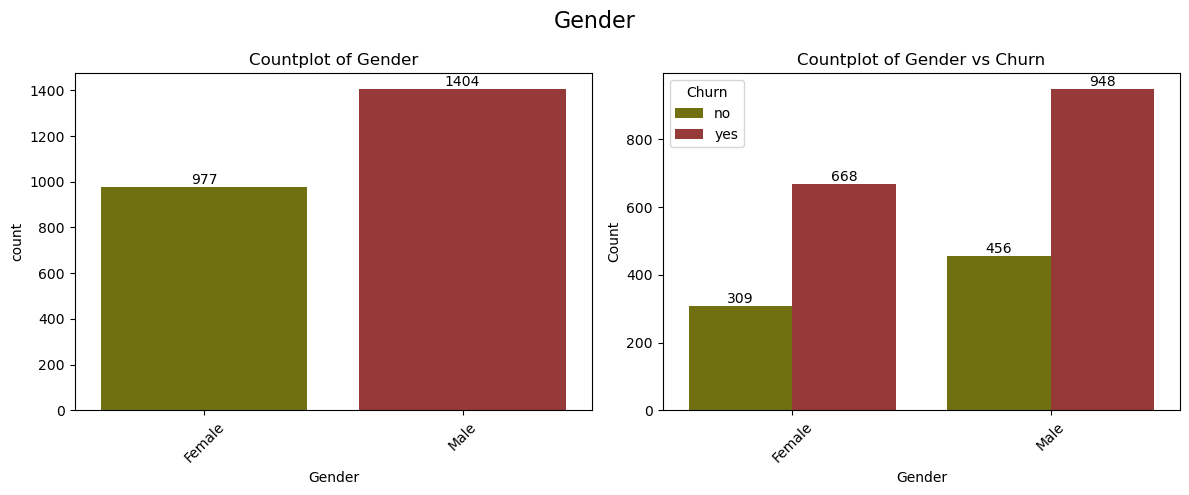

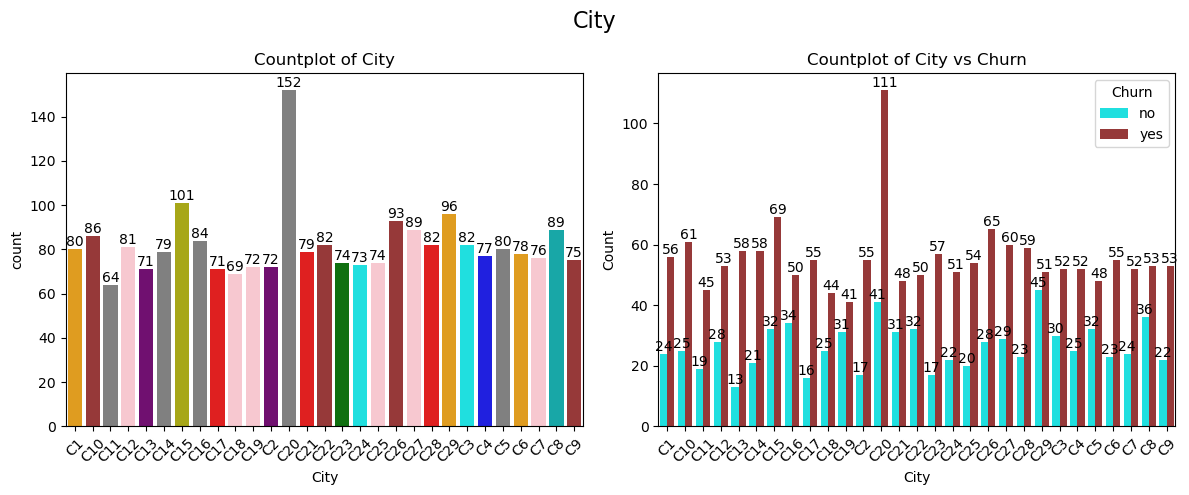

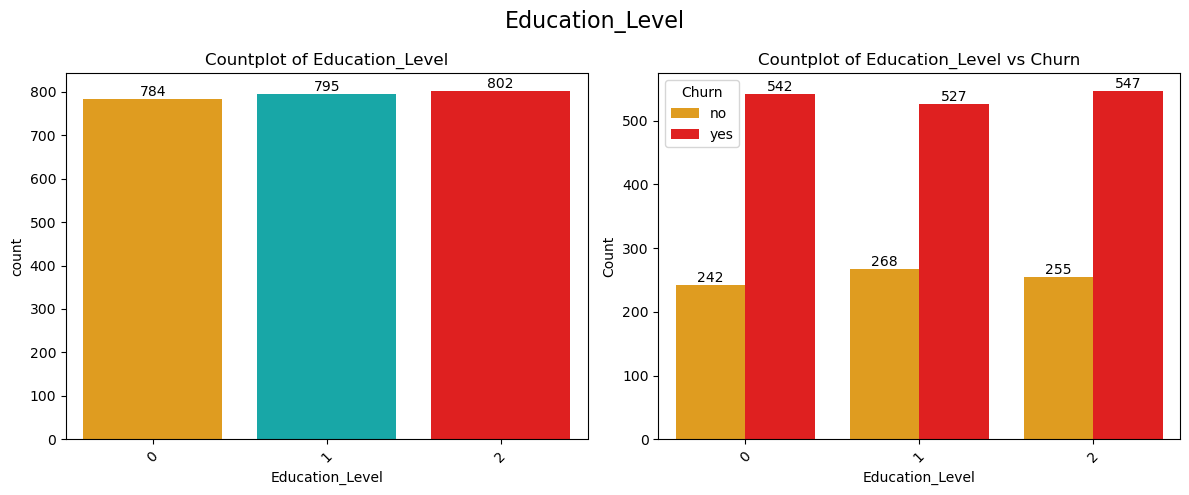

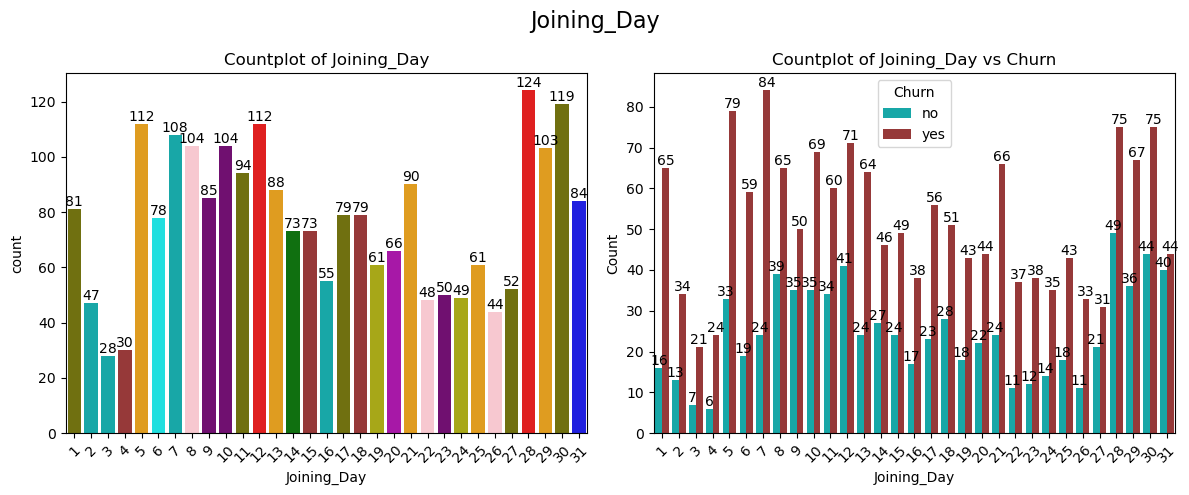

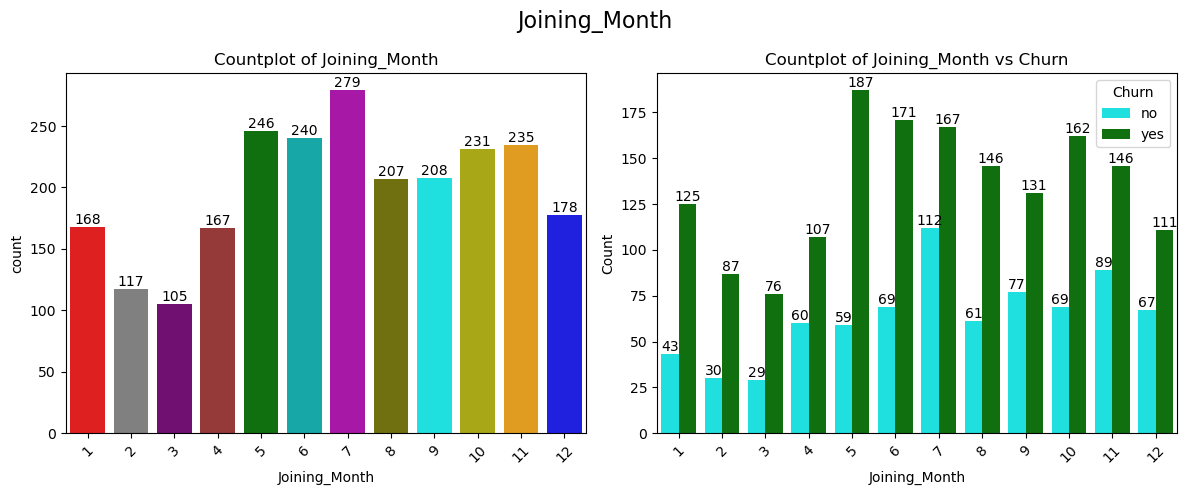

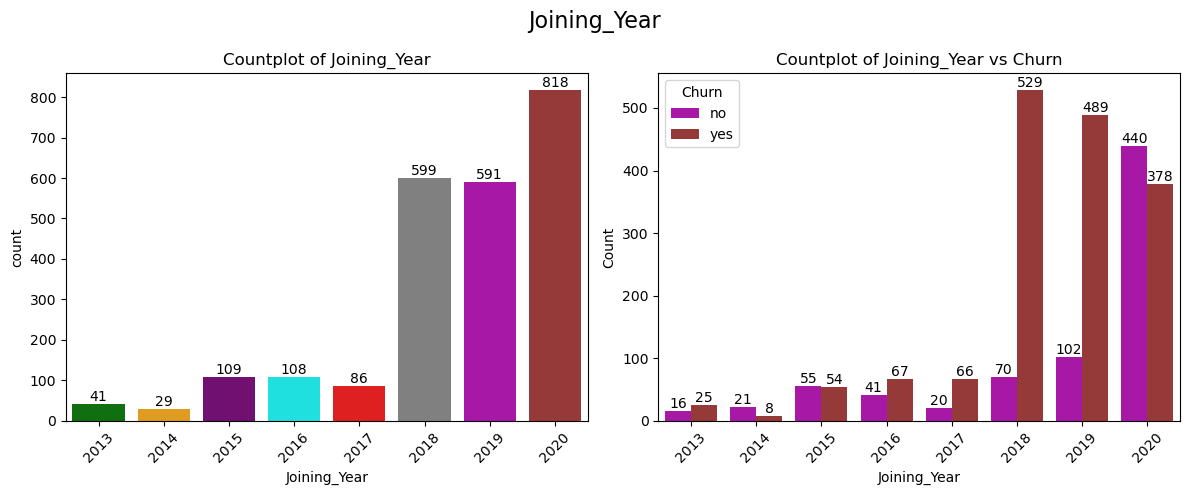

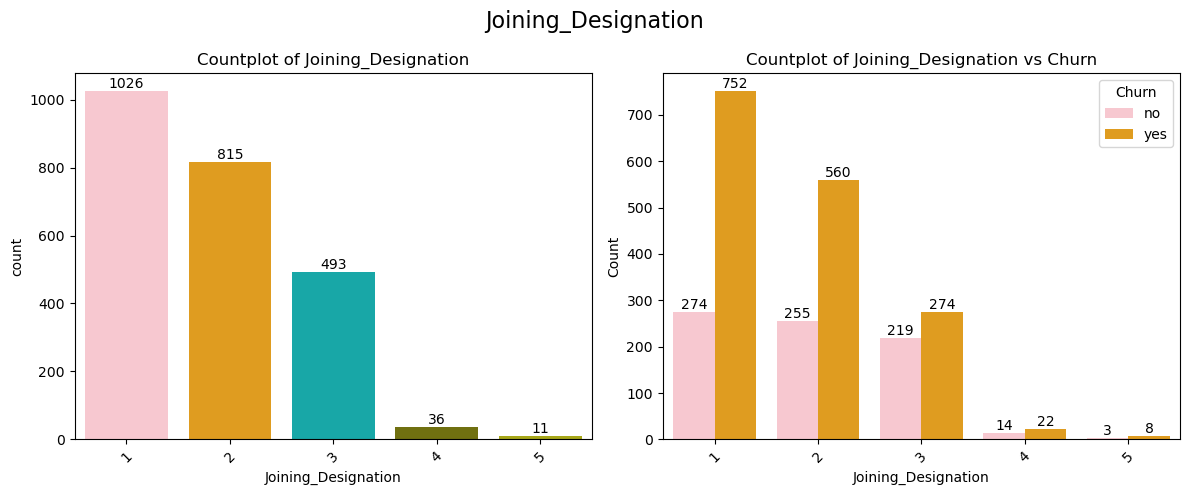

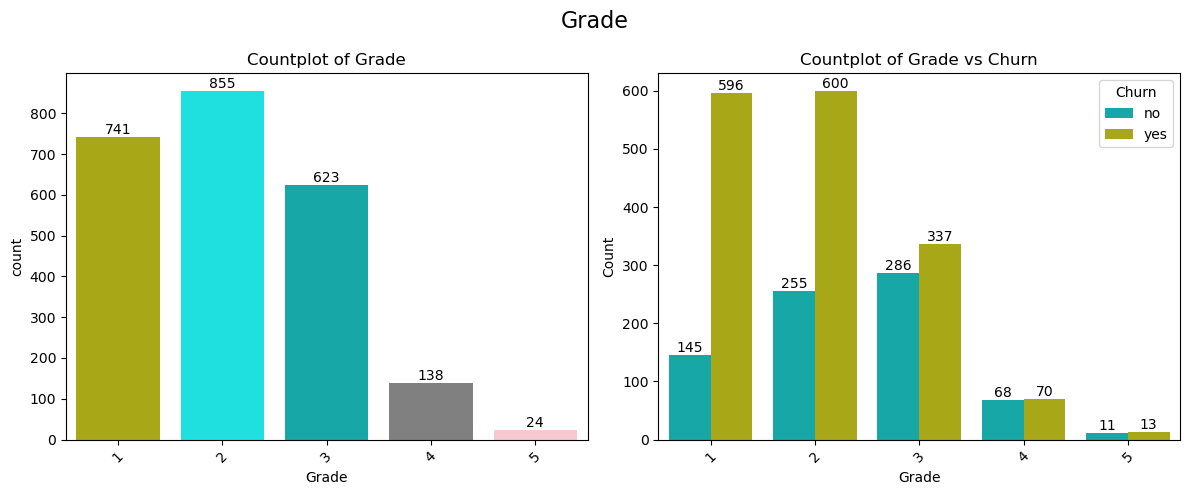

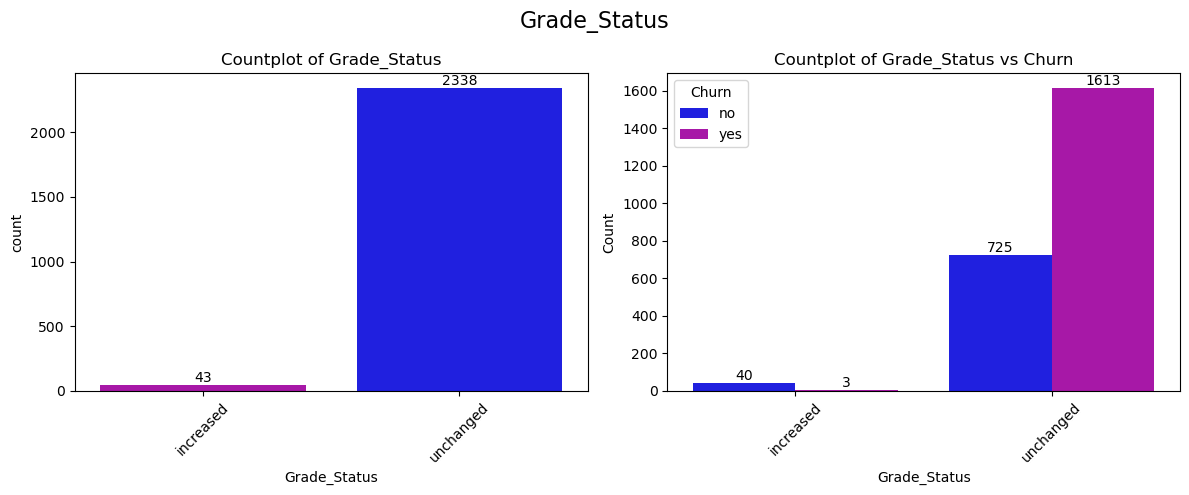

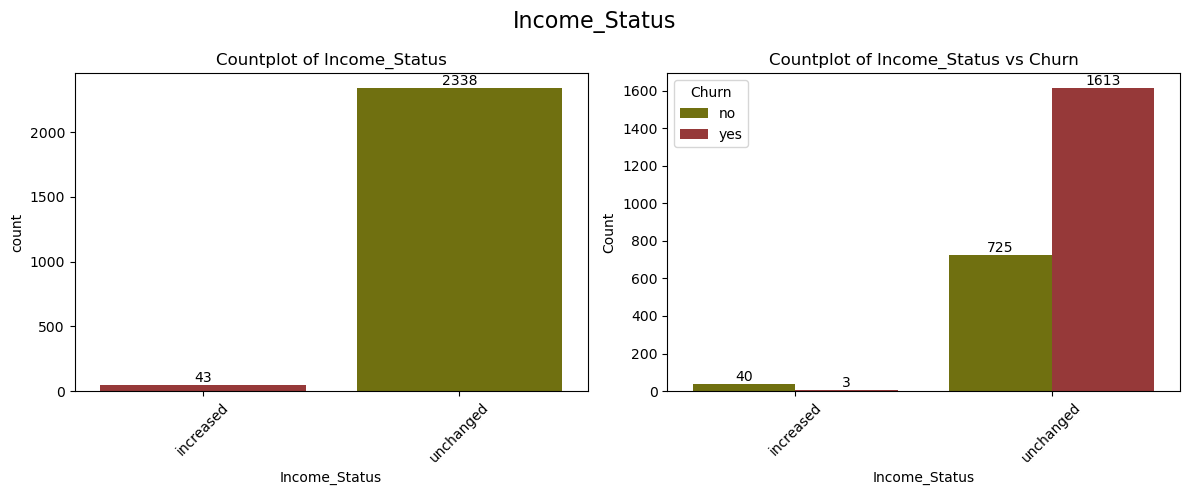

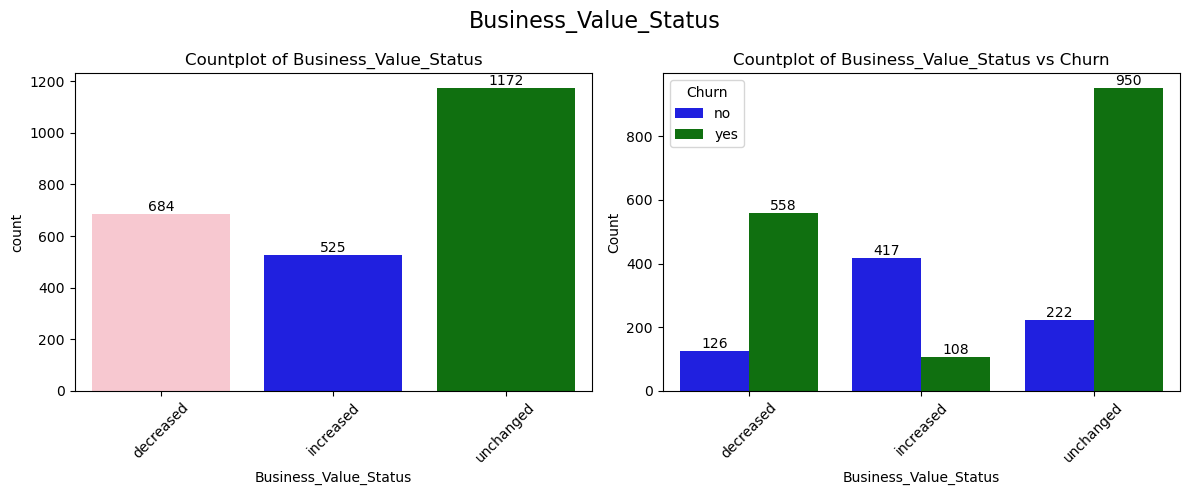

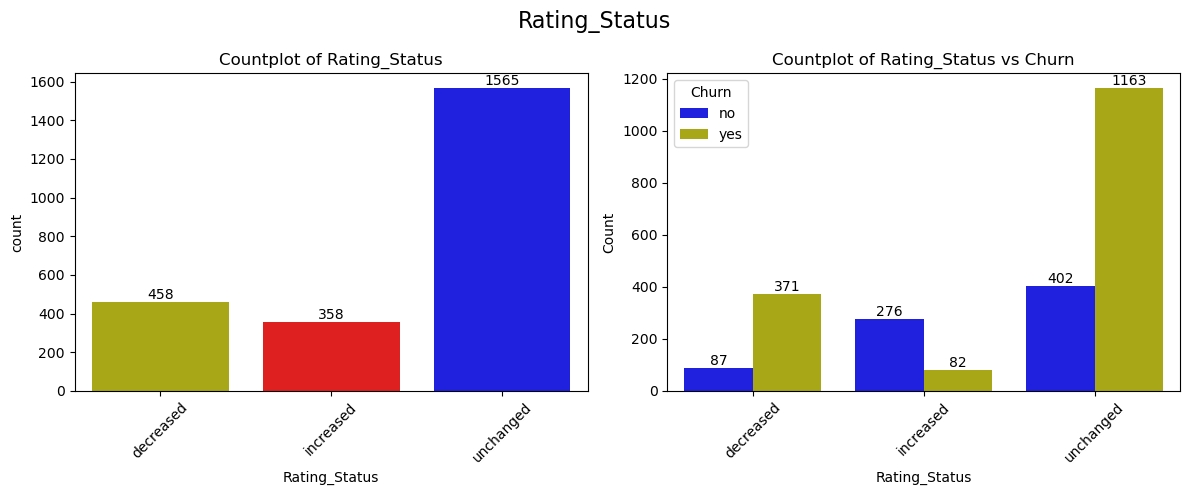

In [ ]:
for col in cat_cols:
    try:
        palette_colors = list(rng.choice(
            colors, size=df[col].nunique(), replace=False))
    except ValueError:
        palette_colors = list(rng.choice(
            colors, size=df[col].nunique(), replace=True))
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'{col}', fontsize=16)
    plt.subplot(1, 2, 1)
    plt.title(f'Countplot of {col}')
    bar1 = sns.countplot(data=df, x=col, hue=col,
                         palette=palette_colors, legend=False)
    plt.xticks(rotation=45)
    for value in bar1.containers:
        bar1.bar_label(value)
    plt.subplot(1, 2, 2)
    plt.title(f'Countplot of {col} vs Churn')
    bar2 = sns.countplot(data=df, x=col, hue='Churn', palette=list(
        rng.choice(palette_colors, size=2, replace=False)), legend=True)
    for value in bar2.containers:
        bar2.bar_label(value)
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

> **Gender**: There are more male drivers than there are female drivers. We also see that the churn is high for both genders.

> **City**: The city with the highest number (by a huge margin) of drivers is C20. But C20 also has the highest number of churn. The distribution of drivers is more or less uniform for the other cities. However, every city still has a higher number of churn than loyal drivers.

> **Education Level**: It is an almost equal distribution of drivers between the three levels of education (1,2 and 3). We also see that the churn is also pretty much uniform regardless of the education level with almost two-thirds churning.

> **Joining Day, Month**: There is no real pattern to be seen. We do see that most number of drivers sign up towards the end of the month and also in the summer months. However, regardless of that, there is still overwhelming number of churns whichever day/month.

> **Joining Year**: We see that churn has increased exponentially in the years 2018-20 compared to the earlier years. It could be that the initial offerings by the company was far more lucrative.

> **Joining Designation**: Most drivers join at the designation 1 and least of all at level 5. However, the churn is most also at level 1 and it is better for higher designation levels. This suggests that drivers joining at higher levels are less likely to churn.

> **Grade**:  Most drivers have grade 1 and 2. Drivers with grades 1 and 2 have the most churn. Drivers with higher grades have lesser churn. This suggests that drivers having high grades are less likely to churn.

> **Change in Grade**:  Almost all drivers see no change in grade and the churn is also very high in this case. For those that saw an increase in grade, there is very low churn.

> **Change in Income**:  Almost all drivers see no change in income and the churn is also very high in this case. For the minority that saw an increase, there is very low churn.

> **Change in Business Value**:  The overwhelming majority of drivers had stagnated or decreased business value. The churn was also very high in these cases. However, for the minority who had increased business value, there is low churn.

> **Change in Quarterly Rating**:  The overwhelming majority of drivers had unchanged rating, and also had the most churn. A significant proportion had decreased rating and a similar number had increased rating - the former having much more churn than the latter case.
> 



### **Bivariate Analysis**

#### Pairplots

We can do a pairplot and check for churn patterns:

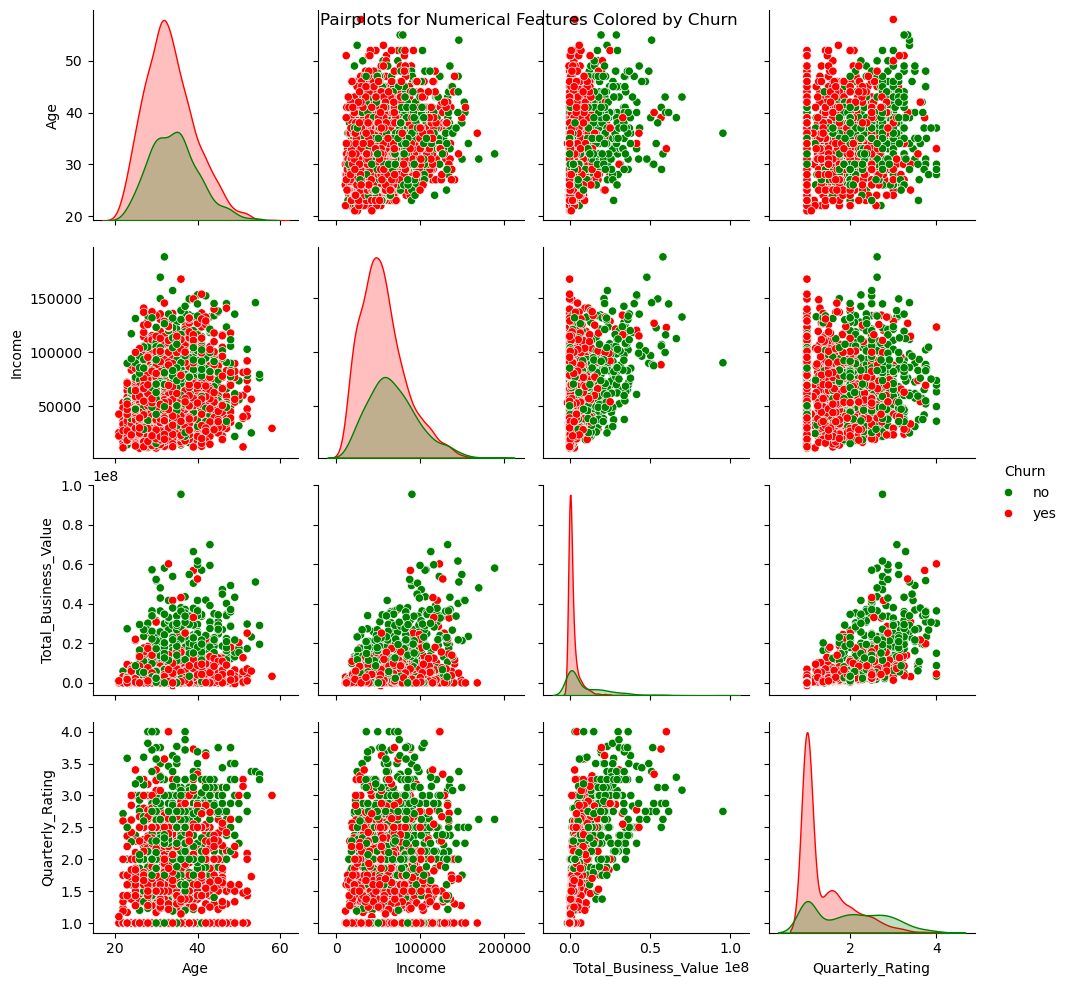

In [ ]:
sns.pairplot(df, hue='Churn', palette=['g', 'r'])
plt.suptitle('Pairplots for Numerical Features Colored by Churn')
plt.show()

> From the pairplots, we are able to confirm what we saw earlier. Drivers with higher income, higher rating and generating higher business values are less likely to churn than drivers with lower income, lower ratings and lower business values.

#### Correlations

Let us also inspect correlations for the numeric features:

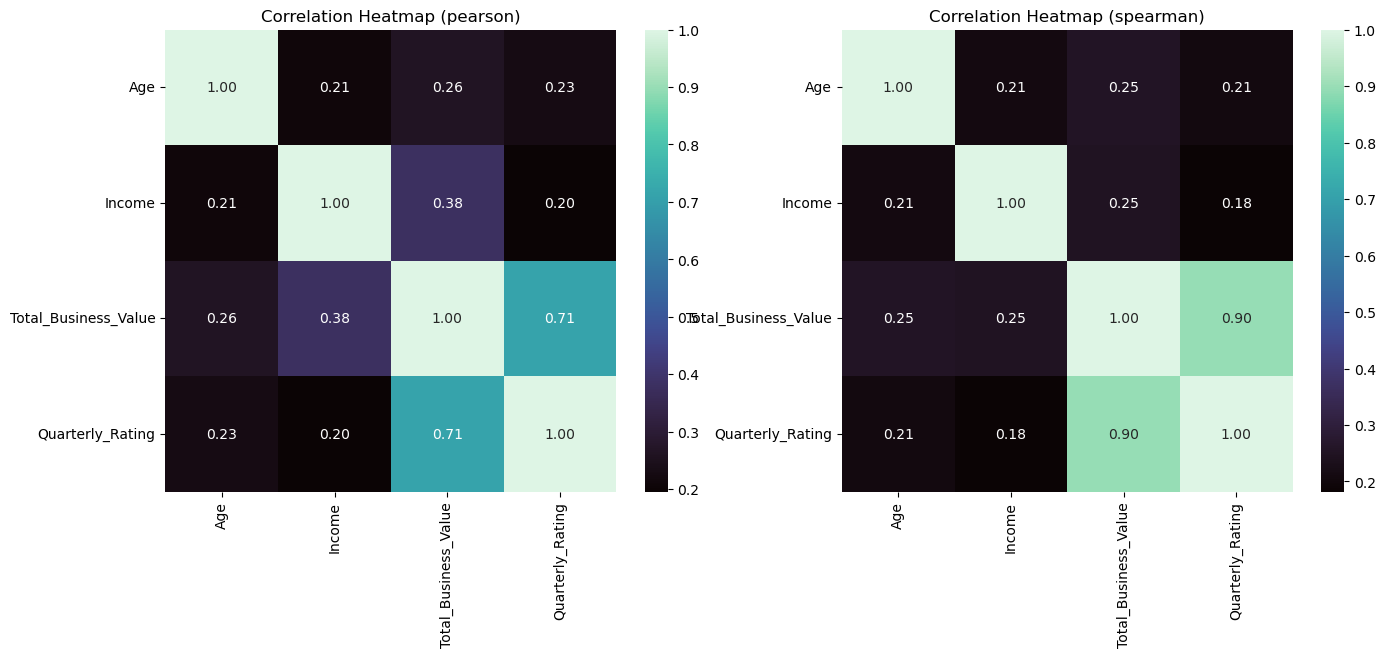

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f",
            cmap=sns.color_palette("mako", as_cmap=True))
plt.title('Correlation Heatmap (pearson)')

plt.subplot(1, 2, 2)
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True,
            fmt=".2f", cmap=sns.color_palette("mako", as_cmap=True))
plt.title('Correlation Heatmap (spearman)')

plt.show()

> We notive a high positive correlation between Quarterly Rating and Total Business Value with pearson coeff of 0.71 and spearman coeff of 0.9! However this is not surprising given that we expect drivers that generate high business value to have high ratings and vice versa. 

> We also see that there is a moderately high positive correlation with pearson coeff of 0.38 between income and business value. This is also to be expected.

> All other features have  positive correlations of both pearson and spearman coefficients ranging from 0.2 to 0.26.

We can also try creating bins for `Age`, `Income` and `Business Value` to inspect any trends with respect to churn.

In [128]:
# df[['Age', 'Income', 'Total_Business_Value']].agg(['min', 'max', 'median'])
# df[['Age', 'Income', 'Total_Business_Value']].describe()[1:]
df[['Total_Business_Value']].describe()[1:]

,Total_Business_Value
mean,4.586742e+06
std,9.127115e+06
min,-1.385530e+06
25%,0.000000e+00
50%,8.176800e+05
75%,4.173650e+06
max,9.533106e+07


In [ ]:
# creating bins for Age, Income and Business Value

age_bins = [20, 35, 50, 60]
age_labels = ['Young', 'Middle_Aged', 'Senior']
df['Age_Bin'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

income_bins = [10000, 40000, 90000, 200000]
income_labels = ['Low', 'Medium', 'High']
df['Income_Bin'] = pd.cut(df['Income'], bins=income_bins, labels=income_labels)

bus_val_bins = [np.min(df['Total_Business_Value'])-1, 0,
                400_000, 1_800_000, 10_500_000, 96_000_000]
bus_val_labels = ['Loss_Making', 'Low', 'Medium', 'High', 'Very_High']
df['Business_Value_Bin'] = pd.cut(
    df['Total_Business_Value'], bins=bus_val_bins, labels=bus_val_labels)

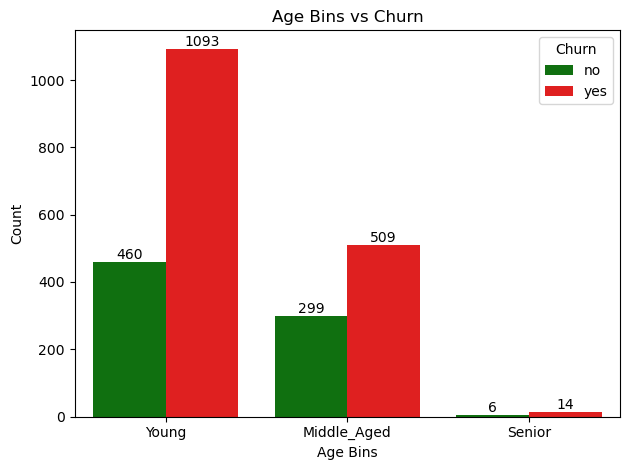

In [ ]:
cnt = sns.countplot(data=df, x='Age_Bin', hue='Churn', palette=['g', 'r'])
for value in cnt.containers:
    cnt.bar_label(value)
plt.title('Age Bins vs Churn')
plt.xlabel('Age Bins')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

> We see that the Young (20-35) drivers are the most likely to churn. There is less churn among the older categories of drivers (Middle Aged and Senior)

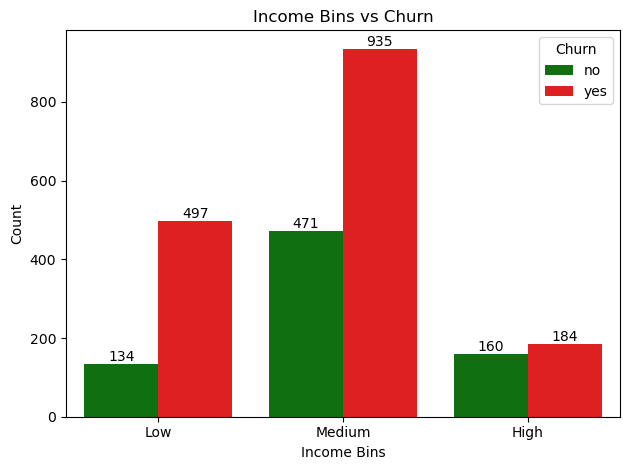

In [ ]:
cnt = sns.countplot(data=df, x='Income_Bin', hue='Churn', palette=['g', 'r'])
for value in cnt.containers:
    cnt.bar_label(value)
plt.title('Income Bins vs Churn')
plt.xlabel('Income Bins')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

> We see that the likelihood of churn is least in the High income category of drivers. For both the Low and Medium income bins, we have very high likelihood of driver churn.

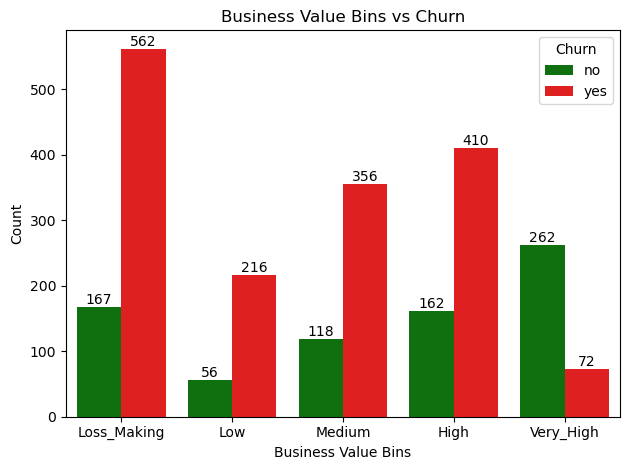

In [ ]:
cnt = sns.countplot(data=df, x='Business_Value_Bin',
                    hue='Churn', palette=['g', 'r'])
for value in cnt.containers:
    cnt.bar_label(value)
plt.title('Business Value Bins vs Churn')
plt.xlabel('Business Value Bins')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

> Overwhelmingly, the Loss Making drivers are most likely to leave the company, followed by Low and Medium categories. Even more High business value generating drivers, we see that the churn is quite high.

> However, For the Very High business value drivers, there is significantly much less churn. In fact, there is more drivers in this category who stay than leave (262 vs 72).

---
## **Data Preprocessing**

Before we start building our models, we will perform any preprocessing required. Such as encoding the categorical columns.

In [211]:
df = pd.read_pickle('df_backup.pkl')
df = df.drop(columns=['Age_Bin', 'Income_Bin', 'Business_Value_Bin'])

In [ ]:
# encoding non-ordinal and ordinal categorical columns

df['Gender'] = (df['Gender'].map({'Male': 0, 'Female': 1})).astype('int8')
df['Churn'] = (df['Churn'].map({'no': 0, 'yes': 1})).astype('int8')
int_cols = ['Joining_Day', 'Joining_Month', 'Joining_Year',
            'Grade', 'Joining_Designation', 'Education_Level']
for col in int_cols:
    if col == 'Joining_Year':
        df[col] = df[col].astype('int16')
    else:
        df[col] = df[col].cat.codes.astype('int8')

change_cols = ['Grade_Status', 'Income_Status',
               'Business_Value_Status', 'Rating_Status']
for col in change_cols:
    df[col] = (df[col].map(
        {'decreased': -1, 'unchanged': 0, 'increased': 1})).astype('int8')

# one-hot encoding for nominal categorical columns
df = pd.get_dummies(df, columns=['City'], dtype='int8')

In [213]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    2381 non-null   float64
 1   Gender                 2381 non-null   int8   
 2   Education_Level        2381 non-null   int8   
 3   Income                 2381 non-null   int64  
 4   Joining_Day            2381 non-null   int8   
 5   Joining_Month          2381 non-null   int8   
 6   Joining_Year           2381 non-null   int16  
 7   Joining_Designation    2381 non-null   int8   
 8   Grade                  2381 non-null   int8   
 9   Total_Business_Value   2381 non-null   int64  
 10  Quarterly_Rating       2381 non-null   float64
 11  Grade_Status           2381 non-null   int8   
 12  Income_Status          2381 non-null   int8   
 13  Business_Value_Status  2381 non-null   int8   
 14  Rating_Status          2381 non-null   int8   
 15  Chur

In [214]:
df

,Age,Gender,Education_Level,Income,Joining_Day,Joining_Month,Joining_Year,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating,Grade_Status,Income_Status,Business_Value_Status,Rating_Status,Churn,City_C1,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,City_C18,City_C19,City_C2,City_C20,City_C21,City_C22,City_C23,City_C24,City_C25,City_C26,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,28.0,0,2,57387,23,11,2018,0,0,1715580,2.000000,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,31.0,0,2,67016,10,5,2020,1,1,0,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,43.0,0,2,65603,11,6,2019,1,1,350000,1.000000,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29.0,0,0,46368,0,8,2019,0,0,120360,1.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,31.0,1,1,78728,30,6,2020,2,2,1265000,1.600000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,34.0,0,0,82815,14,9,2015,1,2,21748820,2.625000,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2377,34.0,1,0,12105,27,7,2020,0,0,0,1.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2378,45.0,0,0,35370,30,6,2018,1,1,2815090,1.666667,0,0,-1,-1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2379,28.0,1,2,69498,20,6,2018,0,0,977830,1.500000,0,0,-1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we can split the data into X and y.

In [216]:
y = df['Churn']
X = df.drop(columns=['Churn'])
X.shape, y.shape

((2381, 44), (2381,))

We split them into the train and test sets (80:20 ratio)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

We know that our model is not perfectly balanced in terms of churn distribution (68-32 split). So we can use SMOTE to address this.

In [219]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train.shape, y_train.shape

((2578, 44), (2578,))

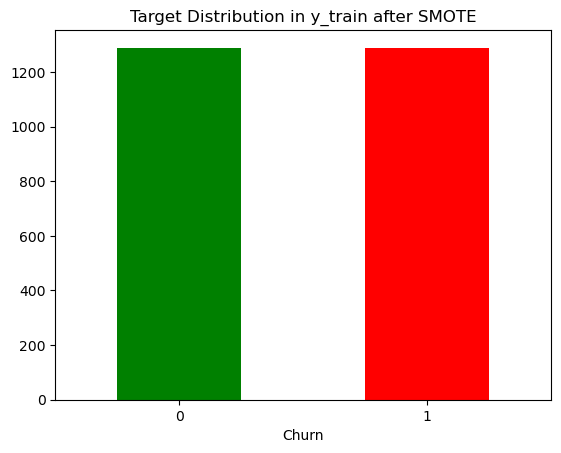

In [226]:
y_train.value_counts().plot(kind='bar', color=['g', 'r'])
plt.title('Target Distribution in y_train after SMOTE')
plt.xticks(rotation=0)
plt.show()

We can also scale the numerical features even though its not strictly necessary for tree-based models.

In [227]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
num_cols = ['Age', 'Income', 'Total_Business_Value', 'Quarterly_Rating']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

We now have the training and testing datasets ready!

In [228]:
# pickle backup
df.to_pickle('df_preprocessed.pkl')
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

---

## **ML Models**

In [2]:
df = pd.read_pickle('df_preprocessed.pkl')
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2578, 44), (2578,), (477, 44), (477,))

We will now build our models on the training data `X_train`, `y_train` and test it on `X_test`, `y_test` and assess their performance. We will create ML models based on both bagging and boosting models, tune the hyper parameters and then depending on the best performance choose a final model.

- Bagging Classifier (`BaggingClassifier`)
- Random Forest (`RandomForestClassifier`)
- Gradient Boost (`GradientBoostingClassifier`)
- XGBoost (`XGBClassifier`)
- LightGBM (`LGBMClassifier`)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define models and hyperparameter grids
models = {
    "BaggingClassifier": {
        "model": BaggingClassifier(random_state=42, n_jobs=-1),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__max_samples": [0.6, 0.8, 1.0],
            "model__max_features": [0.6, 0.8, 1.0]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__criterion": ["gini", "entropy", "log_loss"],
            "model__max_depth": [None, 3, 5, 10],
            "model__min_samples_split": [2, 5, 10],
            "model__max_features": ["sqrt", "log2", None],
            "model__ccp_alpha": [0.0, 0.01, 0.1]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [3, 5, 7],
            "model__eta": [0.01, 0.1, 0.2, 0.5],
            "model__gamma": [0.0, 0.01, 0.1, 0.3, 0.5]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42,n_jobs=-1),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__max_depth": [-1, 5, 10],
            "model__learning_rate": [0.01, 0.1, 0.2, 0.5],
            "model__num_leaves": [31, 63, 127]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 150, 200],
            "model__learning_rate": [0.01, 0.1, 0.3, 0.4, 1]
        }
    }
}

results = {}

for name, mp in models.items():
    print(f"\n--- {name} ---")

    # Build pipeline
    pipe = Pipeline([
        ("model", mp["model"])
    ])

    # Hyperparameter tuning with cross-validation
    search = GridSearchCV(
        estimator=pipe,
        param_grid=mp["params"],
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = search.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # print("Best CV Score:", search.best_score_)
    # print("Best Params:", search.best_params_)
    # print("Test Accuracy:", acc)
    # print(classification_report(y_test, y_pred))

    results[name] = {
        "best_score": search.best_score_,
        "best_params": search.best_params_,
        "test_accuracy": acc,
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    }


In [ ]:
# Compare results
print("\n=== Summary of Results ===\n")
for k, v in results.items():
    print(
        f"{k}: CV Score={v['best_score']:.4f}, Test Acc={v['test_accuracy']:.4f}")


=== Summary of Results ===

BaggingClassifier: CV Score=0.9170, Test Acc=0.8952
RandomForest: CV Score=0.9147, Test Acc=0.8952
XGBoost: CV Score=0.9178, Test Acc=0.8973
LightGBM: CV Score=0.9248, Test Acc=0.8973
AdaBoost: CV Score=0.8732, Test Acc=0.8553


In [4]:
results_models = [model for model in results]
results_best_score = [results[model]['best_score'] for model in results]
results_test_accuracy = [results[model]['test_accuracy'] for model in results]

In [5]:
data = {'Model': results_models, 'Best CV Score': np.round(
    results_best_score, 4), 'Test Accuracy': np.round(results_test_accuracy, 4)}
results_df = pd.DataFrame(data)
results_df

,Model,Best CV Score,Test Accuracy
0,BaggingClassifier,0.9170,0.8952
1,RandomForest,0.9147,0.8952
2,XGBoost,0.9178,0.8973
3,LightGBM,0.9248,0.8973
4,AdaBoost,0.8732,0.8553


In [6]:
results_df = results_df.melt(id_vars='Model')
results_df.columns = ['Model', 'Measure', 'Value']
results_df

,Model,Measure,Value
0,BaggingClassifier,Best CV Score,0.9170
1,RandomForest,Best CV Score,0.9147
2,XGBoost,Best CV Score,0.9178
3,LightGBM,Best CV Score,0.9248
4,AdaBoost,Best CV Score,0.8732
5,BaggingClassifier,Test Accuracy,0.8952
6,RandomForest,Test Accuracy,0.8952
7,XGBoost,Test Accuracy,0.8973
8,LightGBM,Test Accuracy,0.8973
9,AdaBoost,Test Accuracy,0.8553


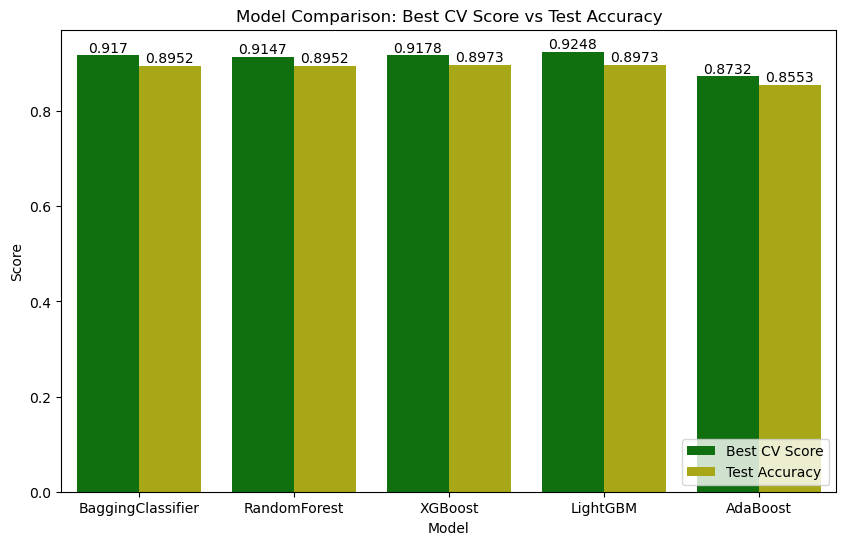

In [11]:
plt.figure(figsize=(10, 6))
bars = sns.barplot(data=results_df, x='Model', y='Value',
                   hue='Measure', palette=['g', 'y'])
for label in bars.containers:
    bars.bar_label(label)
plt.title('Model Comparison: Best CV Score vs Test Accuracy')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='lower right')
plt.show()

> It is clear that LightGBM gives us the best performance with CV Score of 0.9248 and Test Accuracy Score of 0.8973.

We will now traing the model on the entire training set using the best parameters from the grid search.

In [12]:
results['LightGBM']['best_params']

{'model__learning_rate': 0.5,
 'model__max_depth': -1,
 'model__n_estimators': 200,
 'model__num_leaves': 63}

In [13]:
# training lightgbm on entire training set with best parameters

# best params from grid search
learning_rate, max_depth, n_estimators, num_leaves = results['LightGBM']['best_params'].values()

lgbm = LGBMClassifier(random_state=42, learning_rate=learning_rate,
                      max_depth=max_depth, n_estimators=n_estimators, num_leaves=num_leaves)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1289, number of negative: 1289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 2578, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.5
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Let us evaluate its accuracy score and inspect the classification report:

In [33]:
y_pred_test = lgbm.predict(X_test)  # test predictions
y_pred_train = lgbm.predict(X_train)  # train predictions

acc_score_test = accuracy_score(y_test,y_pred_test)
acc_score_train = accuracy_score(y_train,y_pred_train)
classfn_report = classification_report(y_true=y_test, y_pred=y_pred_test)

print("\n--- Final Model Evaluation ---\n")
print(f"The accuracy score on training set is : {acc_score_train:.4}\n")
print(f"The accuracy score on test set is : {acc_score_test:.4}\n")
print(f"The classification report for test set is :\n{classfn_report}")


--- Final Model Evaluation ---

The accuracy score on training set is : 1.0

The accuracy score on test set is : 0.8973

The classification report for test set is :
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       150
           1       0.91      0.94      0.93       327

    accuracy                           0.90       477
   macro avg       0.89      0.87      0.88       477
weighted avg       0.90      0.90      0.90       477



> We have a perfect accuracy of 1.0 on the training data but we also have a high accuracy score of 0.8973 on the test data ie the model predicts with 89.73% accuracy. Since we have a high performance on the test data, we do not have issue of overfitting even with perfect performance on training data.

> In terms of precision, we have 91% precision for positive class (churn) and 86% precision for negative class (no churn)
> A high recall score of 0.94 is very good as it is indicative of strong sensitivity (ability to predict true positives). 

> For Ola, a high recall score for positive class (churn) is very critical because it allows them to identify and subsequently rank the churn-risk drivers and thereby allowing them to target them with initiatives and policies to ensure that they stay with the company.

We can also evaluate the model using the confusion matrix.

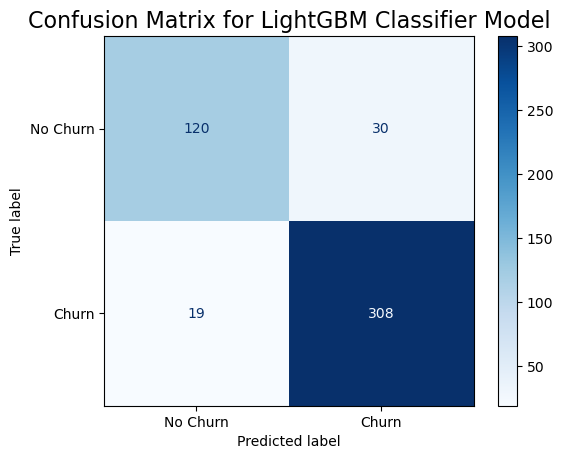

In [15]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm, X_test, y_test, display_labels=[
                                      'No Churn', 'Churn'], cmap='Blues', values_format='d')
plt.title('Confusion Matrix for LightGBM Classifier Model', fontsize=16)
plt.show()

> We see that there are 30 false positives (no churns being identified as churns) and 19 false negatives (churns being identified as no churns). 

Let us also plot the ROC curve for the model and calculate the area under the curve (AUC). This will give us a further metric for evaluating the model's performance.

In [31]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Predict probabilities for ROC curve
y_prob = lgbm.predict_proba(X_test)[:, 1] # prob for y=1

# AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob) 
roc_auc2 = auc(fpr, tpr) # this also works
roc_auc, roc_auc2

(0.9377777777777777, 0.9377777777777777)

> The AUC-ROC score for our model is 0.938


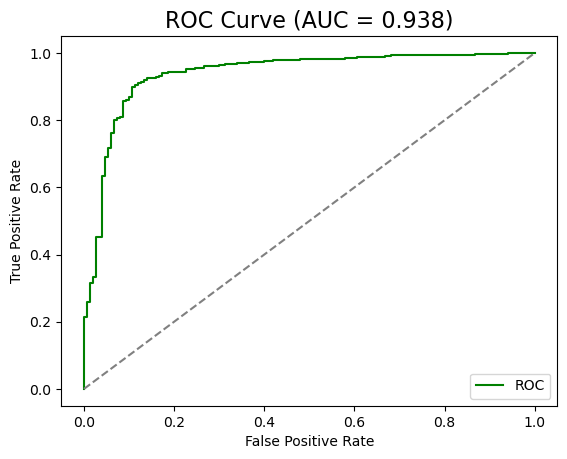

In [ ]:
#plotting the ROC curve

# sns.lineplot(x=fpr, y=tpr, label='ROC', color='g')
plt.plot(fpr,tpr, label='ROC', color='g')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})', fontsize=16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

> We have a very high AUC score of 0.938.

> This means that the model is very effective in distinguishing between positive and negative classes ie it can discriminate the churning and non-churning drivers very well. 

Let us now inspect the feature importances as per our lightgbm classifier model.

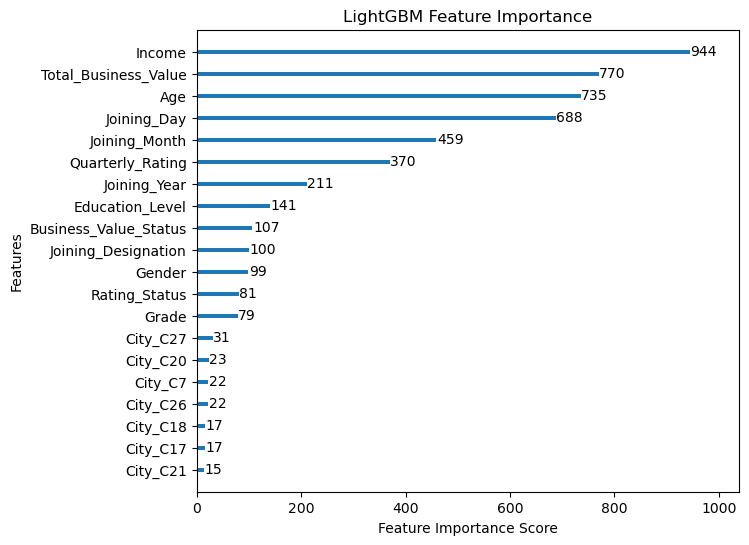

In [23]:
from lightgbm import plot_importance

plot_importance(lgbm, importance_type="auto", figsize=(7, 6),
                title="LightGBM Feature Importance", max_num_features=20,grid=False)
plt.xlabel('Feature Importance Score')
plt.show()

> The above plot shows the top 20 predictors based on our model. According to our model, driver churn is most impacted by these features.

> Income, Total Business Value and Age are the top 3 most important features.

> To a lesser extent, we see that Quarterly Rating, Education Level, Business Value Status and Joining Designation are also important features in churn prediction. 

In [17]:
# backing up the model

import pickle
with open('lgbm_model_final.pkl', 'wb') as f:
    pickle.dump(lgbm, f)

In [18]:
# loading the model
# import pickle
# with open('lgbm_model_final.pkl', 'rb') as f:
#     lgbm_loaded = pickle.load(f)

---
## **Insights and Recommendations**

## **Business Insights**

### **Churn Insights**

- Of the driver data available, a significant majority of ~68% of the drivers (1616 in number) are leaving Ola. We see that the churning population produces much less business value and also have lesser median income and also lesser quarterly rating than the drivers who are staying.

- **Income Influence:** Only less than 2% of total number of drivers had their income increase, and most churned drivers had relatively lower incomes (median of ~51,630). This suggests dissatisfaction with pay structures and incentive mechanisms, which might not be competitive enough. Income is the most important feature according to the model.

- **Quarterly Ratings and Business Value:** Drivers with lower quarterly ratings and generating low business value are more likely to churn. Only 15% drivers had an increase in their quarterly ratings. Less than a quarter of drivers (22%) generated increasing business values.

- **Impact of Driver Age and Tenure:** Younger drivers (20-35 years) and those who joined in recent years have notably higher churn and are more prone to leave. This could be due to insufficient work experience, dissatisfaction with early job roles, or lack of adequate support during their initial period.

- **City-Specific Trends in Churn:** Some cities, such as C20, exhibit a higher proportion of churn in drivers even as they also have the highest proportion of the overall number of drivers. There is also high churn in cities such as C24 to C27.Differences in demand, or operational challenges might be contributing to these disparities in specific cities.

- **Gender and Education:** Even with a male-to-female driver ratio of approximately 60-40, the analysis highlights no stark gender differences, suggesting that both groups face similar challenges. We could therefore explore gender-neutral retention strategies. 
  
  Difference in education levels also does not show any significant impact on churn rates - it virtually uniform across the three levels. 

- **Grade:** We see that drivers with low grades (1 and 2) have extremely high churn rates where as it is much lesser in higher grades (3-5). Moreover, it should be noted that the number of drivers with high ratings (4 and 5) are extremely low. Training for drivers to help them increase their grades could be a strategy to consider.

- Overall, drivers with higher income, higher rating and generating higher business values are less likely to churn than drivers with lower income, lower ratings and generating lower business values.

### **Model Insights**

- **Model Performance Metrics:** After comparing several ML models (bagging -- Bagging and Random Forest Classifiers, and boosting -- Gradient Boost, XGBoost, LightGBM Classifiers), we found that LightGBM Classifier performed the best. Our best model has a high accuracy score of 0.8973 on the test data ie the model predicts with 89.73% accuracy. The model has generalized well even as it has a perfect 1.0 accurace score on the training data.
  
  Another important metric showing the good performance of the model is the AUC-ROC score of 0.94. This shows the discriminatory power of our model in being able to distinguish between the two classes (churn and no churn).
  
  In terms of precision, we have 91% precision for positive class (churn) and 86% precision for negative class (no churn).
  
   A high recall score of 0.94 is very good as it is indicative of strong sensitivity (ability to predict true positives). For Ola, a high recall score for positive class (churn) is very critical - it is more important to correctly identify churn than no churn. Because it allows them to identify and subsequently rank the churn-risk drivers and thereby allowing them to target them with initiatives and policies to ensure that they stay with the company.
  
- **Feature Importances:** Income, Total Business Value and Age are the top 3 most important features. 
 
  To a lesser extent, we see that Quarterly Rating, Education Level, Business Value Status and Joining Designation are also important features in churn prediction. 

### **Recommendations**

- **Driver Performance Enhancement:** Provide training programs and feedback mechanisms for drivers with low quarterly ratings. Partner them with mentors to improve their work experience and performance.

- **Retention Strategies for Younger and More Recent Drivers:** Introduce tailored onboarding programs, periodic role evaluations, and growth opportunities to engage and retain younger drivers as well as recent joinees. Special initiatives and incentives for new drivers can significantly improve retention.

- **Optimize Pay and Incentive Structures:** Design multi-tiered incentives linked to `Total Business Value`, `Quarterly Ratings`, and reporting consistency. Offering bonuses or incremental pay increases to drivers exceeding performance benchmarks can help mitigate churning tendencies.

- **Regional Customization of Operations:** Conduct city-level operational studies to address unique challenges faced in high-churn regions such as C20. Modify policies, shift timings, or demand management strategies to cater to regional needs effectively.

- **Feedback and Model Adaptation:** Given that the transportation industry is dynamic, it is critical to ensure ensure continuous monitoring and adaptability of the ML model. There shold be a periodic review to assess the model performance and continued relevance. New trends and concerns could be identified through surveys or
feedback mechanisms and incorporated to refine the model.

---
**Conclusion:** Our analysis has unearthed key factors influencing driver churn, including performance metrics, age, income levels, etc. By addressing these areas through specific, targeted training and incentives, and enhanced support mechanisms, Ola can significantly improve driver retention, operational efficiency, and long-term profitability.

---